<a href="https://colab.research.google.com/github/gustavoramos82/maratona-tech-rs/blob/main/Notebooks/Apliac%C3%A7%C3%A3o_modelo_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão defluencia

neste dataset será feito uma previsão simples de defluencia como base no artigo [aqui](https://anais.abrhidro.org.br/job.php?Job=12879) já que podemos usar esse estudo para um maior controle e mitigação das barragens de hidrelétricas.

In [1]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/gustavoramos82/maratona-tech-rs/main/Datasets%20Utilizados/Reser%20barra%20grande.csv'

defluencia = pd.read_csv(url)
defluencia.drop(['Unnamed: 0','codigo'],axis=1,inplace=True)
defluencia.head()

,data,defluencia
0,2000-01-01,46.24
1,2000-01-03,242.87
2,2000-01-04,245.59
3,2000-01-08,67.43
4,2000-01-09,76.09


In [3]:
defluencia['data'] = pd.to_datetime(defluencia['data'],format='%Y-%m-%d')
defluencia.head()

,data,defluencia
0,2000-01-01,46.24
1,2000-01-03,242.87
2,2000-01-04,245.59
3,2000-01-08,67.43
4,2000-01-09,76.09


In [4]:
defluencia.tail(10)

,data,defluencia
8037,2021-12-23,101.0
8038,2021-12-24,72.0
8039,2021-12-25,51.0
8040,2021-12-26,20.0
8041,2021-12-30,64.0
8042,2022-01-03,98.0
8043,2022-01-04,87.0
8044,2022-01-06,128.0
8045,2022-01-09,135.0
8046,2022-01-11,243.0


In [5]:
treino = defluencia.iloc[0:8028,:]
teste = defluencia.iloc[8028:8046,:]

In [6]:
def optimize_SARIMA(parameters_list, d, D, s, exog):

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [7]:
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [8]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['defluencia'])
result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 1, 1)",3984.317905
1,"(1, 2, 2, 2)",113715.258003
2,"(2, 2, 1, 2)",113738.146045
3,"(2, 1, 2, 2)",113799.477105
4,"(2, 2, 2, 2)",113803.198526
...,...,...
76,"(1, 1, 0, 0)",118746.905434
77,"(2, 0, 0, 0)",120927.451337
78,"(0, 1, 0, 0)",120973.310253
79,"(1, 0, 0, 0)",121035.399991


In [23]:
# order=(1, 1, 2), seasonal_order=(2, 1, 2, 4)
best_model = SARIMAX(treino['defluencia'], order=(1, 1, 2), seasonal_order=(2, 2, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        defluencia   No. Observations:                 8028
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 4)   Log Likelihood              -59725.986
Date:                           Mon, 27 May 2024   AIC                         119467.973
Time:                                   15:39:13   BIC                         119523.890
Sample:                                        0   HQIC                        119487.110
                                          - 8028                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5672      0.005   -120.683      0.000      -0.576      -0.558
ma.L1         -0.0517      2.252     -0.023

In [10]:
len(teste)

18

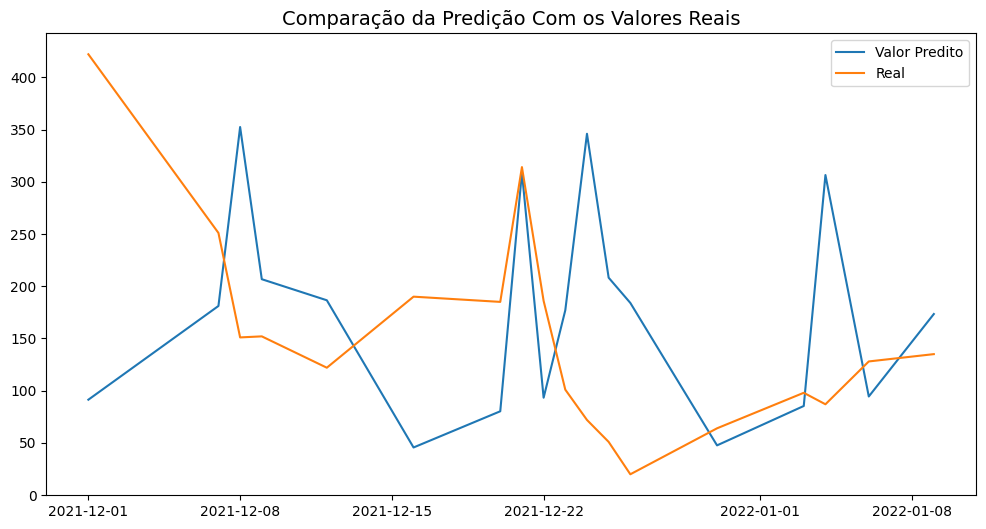

In [24]:


fc = best_model.forecast(18, alpha=0.05)

plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.data,fc,label='Valor Predito')
plt.plot(teste.data,teste['defluencia'].values,label='Real')
plt.legend()



In [25]:
print('MAPE:',mean_absolute_percentage_error(teste['defluencia'],fc))
print('MAE:',mean_absolute_error(teste['defluencia'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['defluencia'],fc)))

MAPE: 1.3564337142030694
MAE: 114.40040374210113
RMSE: 146.41766428350576


In [26]:
best_model = SARIMAX(defluencia['defluencia'], order=(1, 1, 2), seasonal_order=(2, 2, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        defluencia   No. Observations:                 8047
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 4)   Log Likelihood              -58275.794
Date:                           Mon, 27 May 2024   AIC                         116567.589
Time:                                   15:42:10   BIC                         116623.524
Sample:                                        0   HQIC                        116586.730
                                          - 8047                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3558      0.008     46.040      0.000       0.341       0.371
ma.L1         -0.7942      0.714     -1.112

In [27]:
fc = best_model.forecast(30, alpha=0.05)
fc

8047    152.339158
8048    103.024979
8049    109.248651
8050    173.273400
8051    120.236689
8052    115.396715
8053    121.624049
8054    207.676199
8055    135.752014
8056    108.569206
8057    114.689745
8058    189.734669
8059    127.336363
8060    111.341916
8061    117.438368
8062    198.055147
8063    130.926904
8064    109.328585
8065    115.337131
8066    193.216824
8067    128.501381
8068    109.680858
8069    115.655905
8070    194.952004
8071    129.080726
8072    108.882372
8073    114.774244
8074    193.421236
8075    128.166887
8076    108.622881
Name: predicted_mean, dtype: float64

In [32]:
previsão = pd.DataFrame(fc).reset_index().drop('index',axis=1)
previsão.to_csv('Previsão Sarima defluencia')